In [536]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import ipywidgets as widgets
from IPython.display import display, clear_output

In [537]:
df = pd.read_csv('/content/sample_data/2025-grievances.csv')
df['Grievance Date'] = pd.to_datetime(df['Grievance Date'])

In [538]:

mask = df['Sub Category'] == 'Street Light Not Working'
df_sub = df[mask].copy()

In [539]:
daily = df_sub.groupby(df_sub["Grievance Date"].dt.date).size().reset_index(name='count')
daily['date'] = pd.to_datetime(daily['Grievance Date'])
daily = daily[['date', 'count']]

In [540]:
full_range = pd.date_range(daily['date'].min(), daily['date'].max(), freq='D')
daily = daily.set_index('date').reindex(full_range, fill_value=0).rename_axis('date').reset_index()

In [541]:
daily['month'] = daily['date'].dt.month
daily['month_sin'] = np.sin(2 * np.pi * daily['month'] / 12)
daily['month_cos'] = np.cos(2 * np.pi * daily['month'] / 12)
daily['dayofweek'] = daily['date'].dt.dayofweek
daily['dow_sin'] = np.sin(2 * np.pi * daily['dayofweek'] / 7)
daily['dow_cos'] = np.cos(2 * np.pi * daily['dayofweek'] / 7)
festival_dates = ['2025-03-29', '2025-04-12', '2025-05-16']
daily['is_festival'] = daily['date'].astype(str).isin(festival_dates).astype(int)
daily['count_lag1'] = daily['count'].shift(1).fillna(0)
daily['count_lag2'] = daily['count'].shift(2).fillna(0)
daily['log_count'] = np.log1p(daily['count'])
daily['count_lag7'] = daily['count'].shift(7).fillna(0)      # last week
daily['count_rolling_max7'] = daily['count'].rolling(7, min_periods=1).max().shift(1).fillna(0)
daily['count_rolling_sum7'] = daily['count'].rolling(7, min_periods=1).sum().shift(1).fillna(0)


In [542]:
holiday_dates = [
    '2025-01-01','2025-01-14','2025-01-26','2025-03-29','2025-04-12',
    '2025-05-01','2025-08-15','2025-10-02','2025-11-01','2025-12-25'
]

In [543]:
daily['is_holiday'] = daily['date'].astype(str).isin(holiday_dates).astype(int)

np.random.seed(0)
daily['rain_mm'] = np.random.gamma(3, 4, size=len(daily))

In [544]:
features = [
    'count', 'count_lag1', 'count_lag2', 'count_lag7',
    'count_rolling_max7', 'count_rolling_sum7',
    'month_sin', 'month_cos', 'dow_sin', 'dow_cos',
    'is_festival', 'is_holiday', 'rain_mm'
]

In [ ]:
X_all = daily[features].values.astype(float)
y_all = daily['log_count'].values.astype(float) 

In [546]:
def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
sequence_length = 30 

In [548]:
X_seq, y_seq = create_sequences(X_all, y_all, sequence_length)

In [549]:
split = int(0.8*len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [550]:
# --- Scale only on training data ---
feature_scaler = MinMaxScaler()
X_train_reshape = X_train.reshape(-1, X_train.shape[2])
X_test_reshape = X_test.reshape(-1, X_test.shape[2])
X_train_scaled = feature_scaler.fit_transform(X_train_reshape).reshape(X_train.shape)
X_test_scaled = feature_scaler.transform(X_test_reshape).reshape(X_test.shape)


In [551]:
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1,1)).flatten()

In [552]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [553]:
tf.random.set_seed(42)
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.15),
    LSTM(64, return_sequences=True),
    Dropout(0.10),
    LSTM(32),
    Dense(32, activation="relu"),
    Dense(1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [554]:
model.compile(optimizer='adam', loss='mae')
es = EarlyStopping(patience=15, restore_best_weights=True)

In [ ]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=300,            
    batch_size=4,         
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[es],
    verbose=1
)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.5486 - val_loss: 0.2402
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2689 - val_loss: 0.2043
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2123 - val_loss: 0.2660
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2254 - val_loss: 0.2069
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2119 - val_loss: 0.2024
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2190 - val_loss: 0.2128
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2027 - val_loss: 0.2377
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2062 - val_loss: 0.2066
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1996 - val_loss: 0.2014
Epoch 10/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1998 - val_loss: 0.2071
Epoch 11/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2028 - val_loss: 0.2044
Epoch 12/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1980 - val_l

In [556]:
# --- PREDICT AND INVERSE TRANSFORM ---
y_pred_scaled = model.predict(X_test_scaled)
y_pred_log = target_scaler.inverse_transform(y_pred_scaled).flatten()
y_test_log = target_scaler.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()
y_pred_counts = np.expm1(y_pred_log)
y_test_counts = np.expm1(y_test_log)
dates_for_test = daily['date'][split+sequence_length:]

print("First 10 predicted count:", y_pred_counts[:10])
print("First 10 actual count:", y_test_counts[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
First 10 predicted count: [314.6459  314.51483 314.35556 314.2168  314.04938]
First 10 actual count: [194. 319. 348. 334. 315.]


In [557]:
mae = mean_absolute_error(y_test_counts, y_pred_counts)
rmse = np.sqrt(mean_squared_error(y_test_counts, y_pred_counts))
mape = np.mean(np.abs((y_test_counts - y_pred_counts) / (y_test_counts + 1e-6))) * 100
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

MAE: 35.90, RMSE: 56.74, MAPE: 15.90%


In [558]:
window_size = 30
rolling_mean = pd.Series(y_test_counts).rolling(window_size, min_periods=1).mean()
rolling_std = pd.Series(y_test_counts).rolling(window_size, min_periods=1).std()
spike_thresh = rolling_mean + 1.0 * rolling_std

In [559]:
model_spike = y_pred_counts > spike_thresh.values
actual_spike = y_test_counts > spike_thresh.values

In [560]:
TP = np.sum(model_spike & actual_spike)
FP = np.sum(model_spike & (~actual_spike))
FN = np.sum((~model_spike) & actual_spike)

In [561]:
precision = TP / (TP + FP + 1e-8)
recall = TP / (TP + FN + 1e-8)
print(f"Spike Alert Precision: {precision:.2f}")
print(f"Spike Detection Recall: {recall:.2f}")

Spike Alert Precision: 0.00
Spike Detection Recall: 0.00


In [562]:
#simulating a surge
daily.loc[daily['date'] == pd.to_datetime('2025-06-15'), 'count'] = 2000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

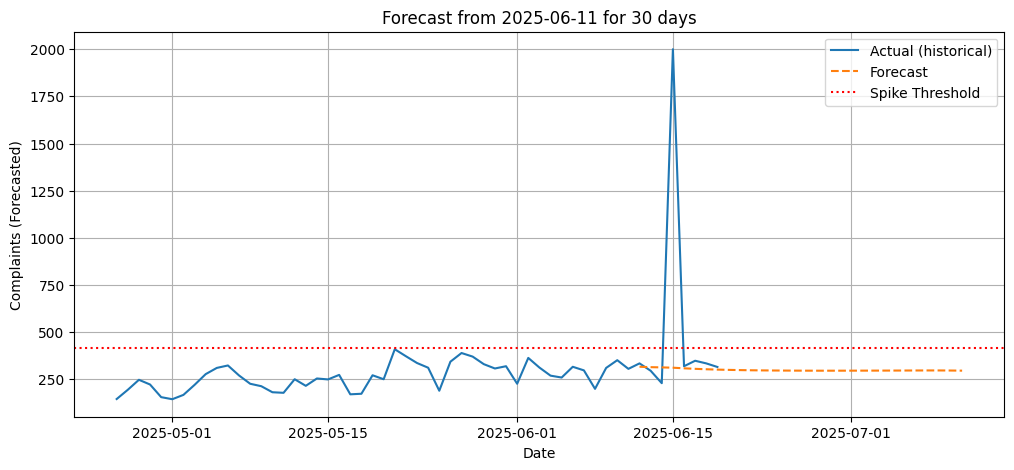

[Info] Spike threshold for this window: 418.2
No spikes predicted.


In [563]:
def interactive_forecast(start_date, days_ahead):
    # Ensure types
    start_date = pd.to_datetime(start_date)
    # Find the last available index <= start_date
    idx = daily[daily['date'] == start_date].index
    if len(idx) == 0 or idx[0] < sequence_length:
        print("Insufficient history before selected start date.")
        return
    idx = idx[0]
    # Prepare last sequence up to the selected start date
    last_seq = X_all[idx-sequence_length:idx]
    last_seq_scaled = feature_scaler.transform(last_seq)
    current_seq = last_seq_scaled.copy()
    future_preds = []
    for i in range(days_ahead):
        pred_scaled = model.predict(current_seq[np.newaxis, :, :])[0, 0]
        pred_log = target_scaler.inverse_transform([[pred_scaled]])[0, 0]
        pred_count = np.expm1(pred_log)
        future_preds.append(pred_count)
        # next input row: only count and lags move
        new_row = current_seq[-1].copy()
        new_row[0] = pred_count  # 'count'
        new_row[1] = current_seq[-1][0]  # count_lag1 = previous count
        new_row[2] = current_seq[-1][1]  # count_lag2 = previous count_lag1
        history_counts = list(daily['count'].iloc[idx-sequence_length:idx]) + future_preds
        last7 = history_counts[-7:]

        new_row[4] = max(last7)     # count_rolling_max7
        new_row[5] = sum(last7)
        # Optionally you could update features (weather, festival) using calendar, etc
        current_seq = np.roll(current_seq, -1, axis=0)
        current_seq[-1] = new_row

    future_dates = pd.date_range(start=start_date + pd.Timedelta(days=1), periods=days_ahead)

    # Compute spike threshold based on the history window prior to the forecast
    hist_counts = daily['count'][:idx]
    rolling_mean = hist_counts.rolling(sequence_length, min_periods=1).mean().iloc[-1]
    rolling_std = hist_counts.rolling(sequence_length, min_periods=1).std().iloc[-1]
    spike_thresh = rolling_mean + 2 * rolling_std

    # Mark spikes
    spikes = [d for d, v in zip(future_dates, future_preds) if v > spike_thresh]

    # Plot actual up to start_date, then prediction
    plt.figure(figsize=(12,5))
    plt.plot(daily['date'], daily['count'], label='Actual (historical)')
    plt.plot(future_dates, future_preds, label='Forecast', linestyle='--')
    plt.axhline(spike_thresh, color='red', linestyle=':', label='Spike Threshold')
    if spikes:
        plt.scatter(spikes, [future_preds[list(future_dates).index(d)] for d in spikes],
                    color='orange', marker='^', label='Predicted Spike')
    plt.title(f"Forecast from {start_date.date()} for {days_ahead} days")
    plt.xlabel('Date')
    plt.ylabel('Complaints (Forecasted)')
    plt.legend()
    plt.grid()
    plt.show()
    print(f"[Info] Spike threshold for this window: {spike_thresh:.1f}")
    if spikes:
        print("Predicted spike dates:", [d.date() for d in spikes])
    else:
        print("No spikes predicted.")

# User widget interface
min_date = daily['date'].iloc[sequence_length]
max_date = daily['date'].iloc[-1]
date_picker = widgets.DatePicker(
    description='Start Date',
    value=max_date,
    disabled=False
)
days_slider = widgets.IntSlider(
    value=30,
    min=1,
    max=60,
    step=1,
    description='Days Ahead'
)

ui = widgets.HBox([date_picker, days_slider])

def on_value_change(change):
    clear_output(wait=True)
    display(ui)
    interactive_forecast(date_picker.value, days_slider.value)

date_picker.observe(on_value_change, names='value')
days_slider.observe(on_value_change, names='value')

display(ui)
interactive_forecast(date_picker.value, days_slider.value)

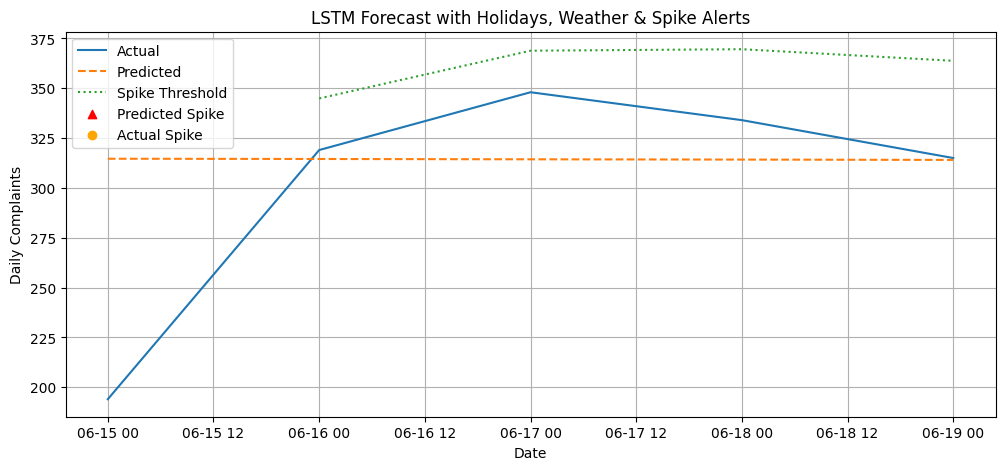

In [564]:
plt.figure(figsize=(12,5))
plt.plot(dates_for_test, y_test_counts, label='Actual')
plt.plot(dates_for_test, y_pred_counts, label='Predicted', linestyle='--')
plt.plot(dates_for_test, spike_thresh, label='Spike Threshold', linestyle=':')
plt.scatter(np.array(dates_for_test)[model_spike], y_pred_counts[model_spike], color='red', label='Predicted Spike', marker='^')
plt.scatter(np.array(dates_for_test)[actual_spike], y_test_counts[actual_spike], color='orange', label='Actual Spike', marker='o')
plt.legend()
plt.title('LSTM Forecast with Holidays, Weather & Spike Alerts')
plt.xlabel('Date')
plt.ylabel('Daily Complaints')
plt.grid()
plt.show()

In [565]:
print("Final train loss:", history.history['loss'][-1])
print("Final val loss:", history.history['val_loss'][-1])


Final train loss: 0.16719333827495575
Final val loss: 0.24672198295593262
